In [27]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import datetime                                           
from matplotlib import pyplot as plt

#Package for machine learning
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from datetime import datetime


import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

In [28]:
# Load the training data
train_data = pd.read_csv('../inf554/train.csv')
#train_data = pd.read_csv("drive/My Drive/Colab Notebooks/inf554/train.csv")
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353969 entries, 0 to 353968
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             353969 non-null  object
 1   retweets_count   353969 non-null  int64 
 2   favorites_count  353969 non-null  int64 
 3   followers_count  353969 non-null  int64 
 4   statuses_count   353969 non-null  int64 
 5   friends_count    353969 non-null  int64 
 6   mentions         353969 non-null  object
 7   urls             353969 non-null  object
 8   verified         353969 non-null  int64 
 9   hashtags         353969 non-null  object
 10  timestamp        353969 non-null  int64 
 11  TweetID          353969 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 32.4+ MB


,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049


***There is no missing data in train_data set***

In [29]:
# Here we split our training data into trainig and testing set.
# This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# I use random_state = 11 so that this model will be deterministic. 
X_train, X_test, y_train, y_test = train_test_split(train_data, train_data['retweets_count'], test_size=0.2, random_state=11)

#### Understanding the importance of each features

In [30]:
# We see that the tweet which owners is verified account is more likely to get retweet
X_train[['verified','retweets_count']].groupby(['verified']).mean()

,retweets_count
verified,
0,11.918964
1,155.408017


In [31]:
#The more favorites the more number of retweets 
X_train[['favorites_count','retweets_count']].groupby(['favorites_count']).mean()

,retweets_count
favorites_count,
0,0.666244
1,1.676055
2,2.100920
3,2.476895
4,2.888215
...,...
89697,40404.000000
96554,13652.000000
100471,63674.000000


In [32]:
#The more followers the more number of retweets 
X_train[['followers_count','retweets_count']].groupby(['followers_count']).mean()

,retweets_count
followers_count,
0,0.101689
1,0.178036
2,0.139745
3,0.168052
4,0.133053
...,...
9863306,2.000000
9863640,12.000000
9867568,9.000000


In [33]:
# the dependence between number of retweets and lenght of text
X_train['retweets_count'].groupby(pd.qcut(X_train['text'].apply(lambda x: len(x)),5)).mean()

text
(5.999, 32.0]      8.736020
(32.0, 51.0]      11.972802
(51.0, 73.0]      12.422868
(73.0, 109.0]     18.745351
(109.0, 279.0]    29.717083
Name: retweets_count, dtype: float64

### Feature Engineering

In [34]:
#drop some features that are irrelevant for our prediction
def drop_feature(data):
    bye = ['hashtags','urls','mentions']
    for i in [data]:
        for j in bye:
            del i[j];
    return data  

In [35]:
#convert text to its length
def len_text(data):
    for i in [data]:
        i['len_text'] = i['text'].apply(lambda x : len(x))
    return data

In [36]:
#Convert timestamp to datetime
def convert_date(data):
    for i in [data]:
        i['date'] = i['timestamp'].apply(lambda x : datetime.fromtimestamp(x / 1000))
    return data

In [37]:
#Track the tweet on which day it is tweeted
def weekday(data):
    for i in [data]:
        i['weekend'] = i['date'].apply(lambda x : x.isoweekday())
    return data

In [38]:
#Convert date time to second 
def convert_sec(data):
    for i in [data]:
        i['sec']  = i['date'].apply(lambda x : x.hour*3600 + x.minute*60 + x.second)
    return data

In [39]:
# Create new feature cos sin of each tweet correspond to the total seconds of the day. 
def cos_sin(data):
    day = 24*60*60
    for i in [data]:
        i['cos'] = i['sec'].apply(lambda x : np.cos(x * (2 * np.pi / day)))
        i['sin'] = i['sec'].apply(lambda x : np.sin(x * (2 * np.pi / day)))
    return data

In [40]:
# drop irrelevant column
def drop(data):
    for i in [data]:
        del i['date']
        del i['sec']
        del i['text']
    return data

In [41]:
# New training data set
X_train= drop_feature(X_train)
X_train= len_text(X_train)
X_train= convert_date(X_train)
X_train= convert_sec(X_train)
X_train = weekday(X_train)
X_train= cos_sin(X_train)
X_train= drop(X_train)

In [42]:
# New testing data set
X_test= drop_feature(X_test)
X_test= len_text(X_test)
X_test= convert_date(X_test)
X_test= convert_sec(X_test)
X_test = weekday(X_test)
X_test= cos_sin(X_test)
X_test= drop(X_test)

<AxesSubplot:>

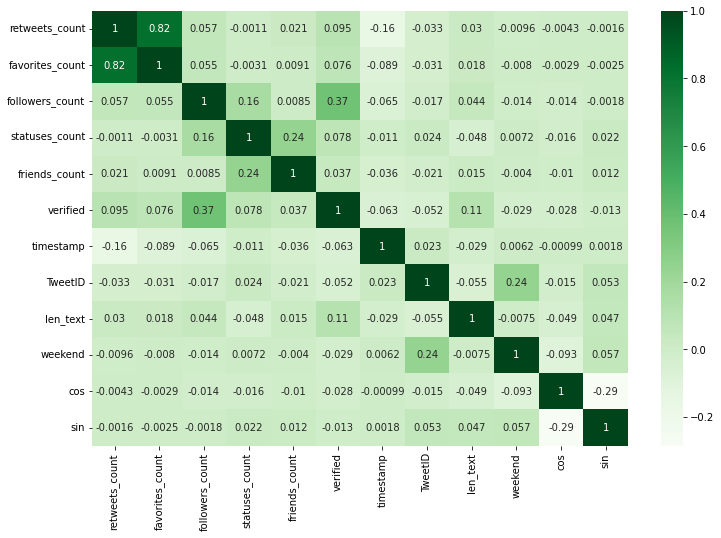

In [43]:
#looking for correlation between features before dropping retweets_count
correlation = X_train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation, cmap="Greens",annot=True)

In [44]:
#Drop number of retweet, since we want to predict it
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)

<AxesSubplot:>

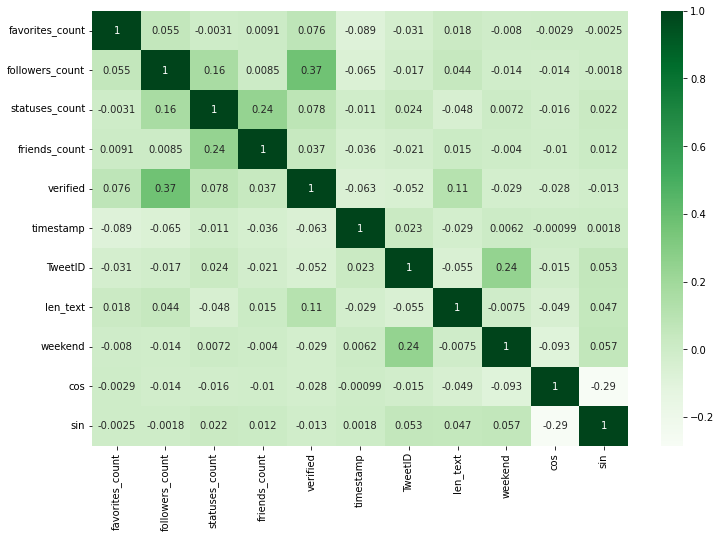

In [45]:
#looking for correlation between features after dropping retweets_count
correlation1 = X_train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation1, cmap="Greens",annot=True)

**We see that the correlation between each features is low, it means that all features are likely independent from each other.**

In [46]:
X_train.head(10)

,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID,len_text,weekend,cos,sin
35311,0,1135,4573,966,0,1647333220000,314162,32,2,-0.802991,0.595991
2609,0,477,30854,1000,0,1647463396000,5549,49,3,0.827244,-0.561843
89796,0,558,36364,647,0,1646908452000,602913,12,4,-0.993670,0.112336
104656,0,2973,60490,2638,0,1647073389000,166543,69,6,-0.774807,0.632198
15880,0,15,1477,41,0,1647453901000,40114,187,3,0.279899,-0.960030
205345,4,455,3170,2176,0,1647025093000,236918,21,5,0.493246,-0.869890
133491,7,87,2722,270,0,1646823395000,862340,67,3,-0.999889,0.014907
304838,0,32,9956,140,0,1647294414000,1064587,22,1,0.949562,-0.313578
281271,93,24884,7966,42,0,1646829506000,628897,86,3,-0.909176,-0.416413
285258,0,1460,9634,3982,0,1647030391000,931894,39,5,0.784010,-0.620749


### Compare performances of some regressors

In [47]:
#Compare all regressors 
# --------------------
#Fit Models
#fit decision tree
# Here we drop tweetID because it means nothing for the prediction.
tree = DecisionTreeRegressor()
tree.fit(X_train.drop(['TweetID'],axis=1), y_train)
# #fit random forest
forest = RandomForestRegressor()
forest.fit(X_train.drop(['TweetID'],axis=1), y_train)
#fit regression
lin_reg = LinearRegression()
lin_reg.fit(X_train.drop(['TweetID'],axis=1), y_train)
#fit XGB
xgb = XGBRegressor()
xgb.fit(X_train.drop(['TweetID'],axis=1), y_train)
# #fit GBR
gbr = GradientBoostingRegressor()
gbr.fit(X_train.drop(['TweetID'],axis=1), y_train)


GradientBoostingRegressor()

In [48]:
#Error of each model, here we use mean absolute error
models= [('lin_reg', lin_reg), ('random forest', forest), ('decision tree', tree),('XGB', xgb),('GradientBoosting', gbr)]
# models= [('random forest', forest)]
for i, model in models:    
    predictions = model.predict(X_test.drop(['TweetID'],axis=1))
    MAE = mean_absolute_error(y_test, predictions)
    print('Prediction error of ', i , 'is ', MAE)

Prediction error of  lin_reg is  9.603221934042974
Prediction error of  random forest is  5.490115028580577
Prediction error of  decision tree is  7.718747351470464
Prediction error of  XGB is  5.593042710281965
Prediction error of  GradientBoosting is  5.952153249541317


We see that the prediction error get from random forest is the smallest, but we decided to use XGB model because it is easier to be tunning and it doesn't cost much. Random forest requires lots of time to be tunning. On the other hand, XGB is more likely suitable because, It's precise (Gradient of the data is considered for each tree, the calculation is faster and the precision is accurate than Random Forest), it adapts well to all types of data and problems, it has excellent documentation, and overall it's very easy to use

### Tunning hyperparameters for Extreme Gradient Discent

We can use either GridSearchCV or RandomizedSearchCV to do tunning. But here we use RandomizedSearchCV because it is less costly.

In [49]:
# Define the grid of hyperparameters to search
# Tunning : we expect smaller max_depth and bigger gamma from this tunning because 
# the smaller max_depth makes models more simple to avoid overfitting 
# and gamma : Minimum loss reduction required to make a further partition on a leaf node of the tree
# source https://xgboost.readthedocs.io/en/latest/parameter.html
hyperparameter_grid = {
    'n_estimators': [100, 500, 700],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4],
    'gamma':[0,0.5,1]
    }

In [50]:
#Doing randomizedsearchCV 
regressor = XGBRegressor()
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=3, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [51]:
random_cv.fit(X_train.drop(['TweetID'],axis=1), y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END gamma=0, learning_rate=0.15, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-4.206, test=-7.097) total time=   8.8s
[CV 2/3] END gamma=0, learning_rate=0.15, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-4.506, test=-6.988) total time=   9.5s
[CV 3/3] END gamma=0, learning_rate=0.15, max_depth=5, min_child_weight=2, n_estimators=100;, score=(train=-5.248, test=-6.436) total time=   9.7s
[CV 1/3] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100;, score=(train=-4.646, test=-7.425) total time=  11.6s
[CV 2/3] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100;, score=(train=-4.993, test=-7.243) total time=   9.7s
[CV 3/3] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100;, score=(train=-5.088, test=-6.442) total time=   9.8s
[CV 1/3] END gamma=0, learning_rate=0.05, max_depth=1

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=4,
                   param_distributions={'gamma': [0, 0.5, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [5, 7, 10],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 700]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [52]:
#best estimator obtained by doing randomizedsearchCV 
random_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [72]:
random_cv.best_params_

{'n_estimators': 500,
 'min_child_weight': 2,
 'max_depth': 7,
 'learning_rate': 0.05,
 'gamma': 1}

In [53]:
# Prediction use the best paramters 
reg1 = random_cv.best_estimator_
# reg1 = XGBRegressor(gamma=1, learning_rate=0.05, 
#              max_cat_threshold=64, max_depth=7, max_leaves=0, min_child_weight=2, 
#              n_estimators=500)
reg1.fit(X_train.drop(['TweetID'],axis=1), y_train)
y_pred = reg1.predict(X_test.drop(['TweetID'],axis=1))
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Prediction error: 5.4572512355641


**Feature Importance**

In [55]:
import xgboost as xgb

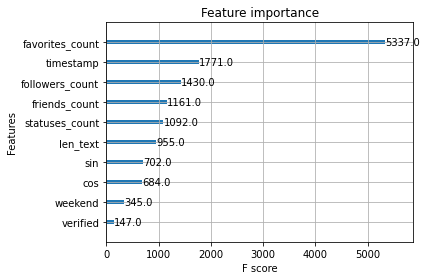

In [56]:
xgb.plot_importance(reg1);
plt.tight_layout()

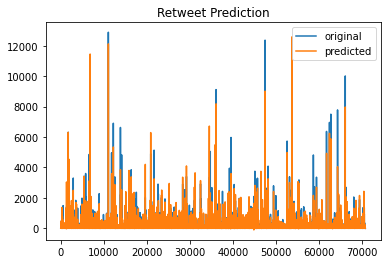

In [57]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Retweet Prediction")
plt.legend()
plt.show()

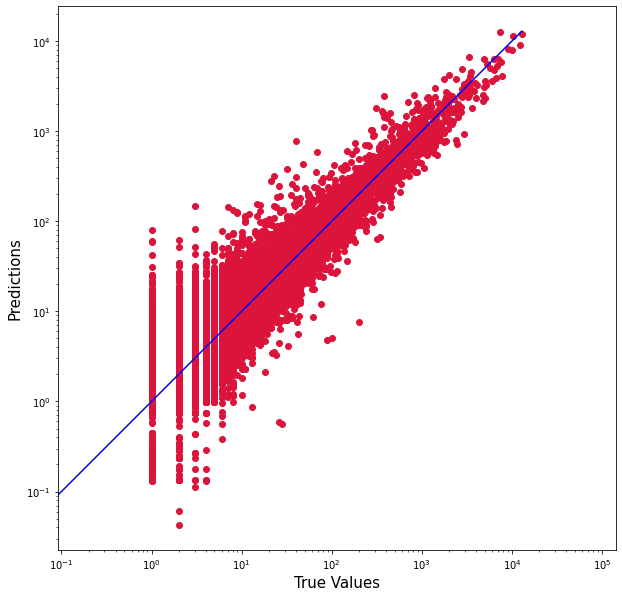

In [58]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Tuning hyperparameters for Random Forest

In [59]:
# Sample training data for tuning models (use full training data for final run)
tuning_sample = 50000
idx = np.random.choice(len(X_train), size=tuning_sample)
X_tuning = X_train.iloc[idx]
y_tuning = y_train.iloc[idx]

In [62]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,20 ,num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [63]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train.drop(['TweetID'],axis=1), y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time= 4.4min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time= 4.4min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time= 4.4min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 6.6min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time= 8.9min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time= 8.9min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time= 8.9min
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time= 5.5min
[CV] END 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [64]:
#best parameters of random forest
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 8,
 'bootstrap': True}

In [65]:
# rf = rf_random.best_params_
rf = rf_random.best_estimator_
# We fit our model using the training data
rf.fit(X_train.drop(['TweetID'],axis=1), y_train)
# And then we predict the values for our testing set
yrf_pred = rf.predict(X_test.drop(['TweetID'],axis=1))
# We want to make sure that all predictions are non-negative integers
yrf_pred = [int(value) if value >= 0 else 0 for value in yrf_pred]

print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=yrf_pred))

Prediction error: 5.551077774952679


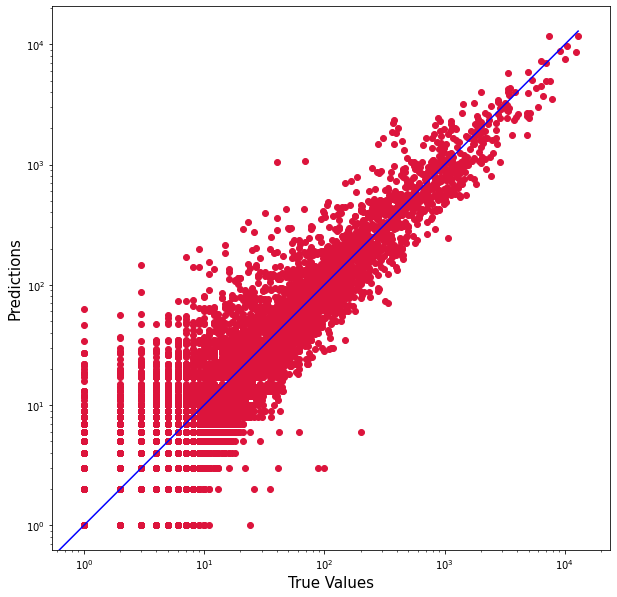

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, yrf_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(yrf_pred), max(y_test))
p2 = min(min(yrf_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Final step

In [67]:
###################################
# Once we finalized our features and model we can train it using the whole training set and then produce prediction for the evaluating dataset
###################################
# Load the evaluation data
eval_data = pd.read_csv("evaluation.csv")
y_train = train_data['retweets_count']
X_train= drop_feature(train_data)
X_train= len_text(X_train)
X_train= convert_date(X_train)
X_train = weekday(X_train)
X_train= convert_sec(X_train)
X_train= cos_sin(X_train)
X_train= drop(X_train)
X_train = X_train.drop(['retweets_count'],axis=1)

In [68]:
X_val= drop_feature(eval_data)
X_val= len_text(X_val)
X_val= convert_date(X_val)
X_val= convert_sec(X_val)
X_val = weekday(X_val)
X_val= cos_sin(X_val)
X_val= drop(X_val)

In [70]:
# We fit our model using the training data
reg = random_cv.best_estimator_
# reg = RandomForestRegressor()
reg.fit(X_train.drop(['TweetID'],axis=1), y_train)
# X_val = vectorizer.transform(eval_data['text'])
# Predict the number of retweets for the evaluation dataset
y_pred = reg.predict(X_val.drop(['TweetID'],axis=1))
y_pred = [int(value) if value >= 0 else 0 for value in y_pred]
# Dump the results into a file that follows the required Kaggle template
with open("gbr_predictions.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(y_pred):
        writer.writerow([str(eval_data['TweetID'].iloc[index]) , str(int(prediction))])

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_val)
with open("mean_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(dummy_pred):
        writer.writerow([str(eval_data['TweetID'].iloc[index]) , str(int(prediction))])

dummy_regr = DummyRegressor(strategy="constant", constant=0)
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_val)

with open("zero_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(dummy_pred):
        writer.writerow([str(eval_data['TweetID'].iloc[index]) , str(int(prediction))])